In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

# Lecture des données

In [2]:
def lecture(fichier):
    with open(fichier, "r") as f:
        nt = []
        re = []
        im = []
        for line in f:
            data = line.split()
            nt.append(data[0])
            re.append(data[1])
            im.append(data[2])
        nt = nt[1:]
        re = re[1:]
        im = im[1:]
        for i in range(len(nt)):
            nt[i] = float(nt[i])
            re[i] = float(re[i])
            im[i] = float(im[i])
        return nt, re, im

In [3]:
fichier = "./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz8.m-0.3303_m-0.3303.n3.dat"
nt, re, im = lecture(fichier)

In [4]:
#listes par configurations
def par_configs(nt,re,im):
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    return ntll, rell, imll

In [5]:
ntll, rell, imll = par_configs(nt,re,im)

In [6]:
#retourne la norme par nt
def normes_par_nt(ntll, rell, imll):
    nont = []
    for i in range(64):
        nonti = []
        for j in range(len(ntll)):
            nonti.append(np.sqrt((rell[j])[i]**2 + (imll[j])[i]**2))
        nont.append(nonti)
    return nont

In [7]:
def re_im_par_nt(rell, imll):
    rent = []
    imnt = []
    for i in range(64):
        renti = []
        imnti = []
        for j in range(len(rell)):
            renti.append(rell[j][i])
            imnti.append(imll[j][i])
        rent.append(renti)
        imnt.append(imnti)
    return rent, imnt

In [8]:
nont = normes_par_nt(ntll, rell, imll)

In [9]:
rent, imnt = re_im_par_nt(rell, imll)

# Premier fit

In [10]:
def moyenne_norme(nont): #renvoie une liste avec les moyennes des normes pour chaque nt, et la liste des erreurs stats associées
    return [np.mean(nont[i]) for i in range(len(nont))], [np.sqrt(np.var(nont[i])) for i in range(len(nont))]

In [11]:
def moyenne_re_im(rent, imnt):
    return [np.mean(rent[i]) for i in range(len(rent))], [np.sqrt(np.var(rent[i])) for i in range(len(rent))], [np.mean(imnt[i]) for i in range(len(imnt))], [np.sqrt(np.var(imnt[i])) for i in range(len(imnt))]

In [12]:
remoy, sigmare, immoy, sigmaim = moyenne_re_im(rent, imnt)

In [13]:
nomoy, sigmaobs = moyenne_norme(nont)
xnt = [i for i in range(64)]

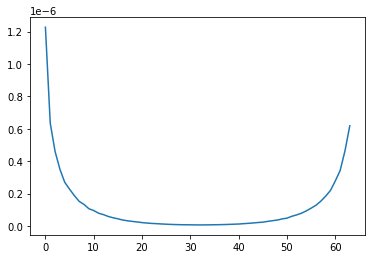

In [14]:
#count,bins  = np.histogram(np.array(immoy)/np.array(remoy))
remoy=np.array(remoy)
plt.plot((nomoy))

Text(0, 0.5, '$ln(C(n_t))$')

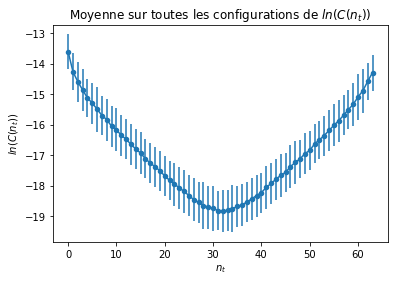

In [15]:
plt.errorbar(xnt,np.log(nomoy), (sigmaobs/np.abs(nomoy)), marker='.', mew=2.5)
plt.title("Moyenne sur toutes les configurations de $ln(C(n_t))$")
plt.xlabel(r"$n_t$")
plt.ylabel(r"$ln(C(n_t))$")

In [16]:
def fit(nt, A0, E0): #la fonction à fit
    return A0*np.cosh((nt-32)*E0)

In [17]:
def estim(inf,sup, nomoy, sigmaobs): #renvoie [A0, E0, chi2, chi2réduit], xdata, ydata, ypred
    xdata = np.array([i for i in range(inf,sup)])
    ydata = np.array(nomoy[inf:sup])
    sigmadata = np.array(sigmaobs[inf:sup])
    popt, pcov = curve_fit(fit, xdata, ydata, sigma = sigmadata)
    A0 = popt[0]
    E0 = popt[1]
    ddl = sup-inf+1-2
    ypred = fit(xdata, A0, E0)
    chi2 = np.sum(((ydata-ypred)/sigmadata)**2)
    chi2red = chi2/ddl
    return [A0, E0, chi2, chi2red], xdata, ydata, ypred, sigmadata

# Effective mass plateau

In [18]:
def plateau(nomoy, sigmaobs):
    chi2 = []
    for i in range(2,31):
        params, xdata, ydata, ypred, sigmadata = estim(31-i, 31+i, nomoy, sigmaobs)
        chi2.append(params[2])
            
    dernier_indice_satisfaisant = -1  # Initialisation avec un indice invalide au cas où aucun élément ne satisfait la condition
    #print(chi2)
    for i, valeur in enumerate(chi2):
        if valeur < 1:
            dernier_indice_satisfaisant = i
    dernier_indice_satisfaisant = dernier_indice_satisfaisant+2
    inf = 31-dernier_indice_satisfaisant
    sup = 31+dernier_indice_satisfaisant
    #print("inf = " + str(inf))
    #print("sup = " + str(sup))
    return inf, sup

In [19]:
inf, sup = plateau(nomoy, sigmaobs)

In [20]:
print(inf, sup)

13 49


On choisit donc comme plateau (13,49) :

In [21]:
params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
print(params[2])

0.022371239783129226


Text(0, 0.5, '$C(n_t)$')

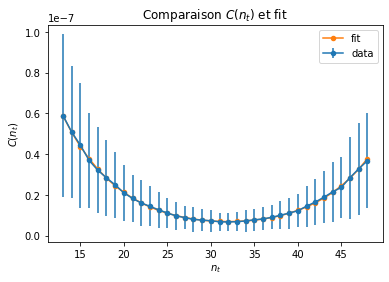

In [22]:
plt.errorbar(xdata, ydata, sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, ypred, marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $C(n_t)$ et fit")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$C(n_t)$")

In [23]:
a =  0.0652
x = (1/a)*197.327
E0 = params[1]
Mphysmev = E0*x
print("Masse physique : " + str(Mphysmev) + " MeV")

Masse physique : 451.8517202568747 MeV


# Détermination des erreurs

## Jacknife

In [24]:
nconf = 999
a =  0.0652
x = (1/a)*197.327

In [25]:
def jack(n, nt, re, im): #retourne les listes des nt, re, im par configuration ou il manque la nième configuration
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    ntll.pop(n)
    rell.pop(n)
    imll.pop(n)
    return ntll, rell, imll

In [26]:
def jacknife(nconf, fichier, a, x):
    nt, re, im = lecture(fichier)
    E0jn = [] #liste des E0 pour chaque set du jacknife
    
    ntll, rell, imll = par_configs(nt,re,im)
    nont = normes_par_nt(ntll, rell, imll)
    nomoy, sigmaobs = moyenne_norme(nont)
    inf,sup = plateau(nomoy, sigmaobs)
    params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
    
    E0 = params[1] #on trouve E0 sans jacknife d'abord
    
    for n in range(nconf): #on fait le jacknife
        
        ntll, rell, imll = jack(n,nt,re,im)
        
        nont = normes_par_nt(ntll, rell, imll)
        
        nomoy, sigmaobs = moyenne_norme(nont)
        
        inf,sup = plateau(nomoy, sigmaobs)
        
        params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
        
        E0jn.append(params[1])
        
        if (n%100==0): #compteur
            print(n)
            
    E0tild = np.mean(np.array(E0jn))
    biais = (len(E0jn)-1)*(E0tild-E0)
    E0unb = E0 - biais
    sigmajn2 = np.sqrt(np.var(E0jn))
    sigmajn = np.sqrt(((nconf-1)/nconf)*np.sum((np.array(E0jn) - np.ones(nconf)*E0)**2))  #Erreur sur E0 estimée par le jacknife
    
    print("E0 biased= " + str(E0) + " +/- " + str(sigmajn))
    print("M biased = " + str(E0*x) + " +/- " + str(sigmajn*x) + " MeV")
    return E0jn, E0, E0unb, sigmajn
    

In [27]:
#E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)

## Bootstrap

In [28]:
def create_set(nt, re, im, nconf):
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    conf = [i for i in range(nconf)]
    ind = random.choices(conf,k=nconf)
    ntll = [ntll[i] for i in ind]
    rell = [rell[i] for i in ind]
    imll = [imll[i] for i in ind]
    return ntll, rell, imll

In [29]:
def bootstrap(nbs, nconf, fichier, a, x):
    nt, re, im = lecture(fichier)
    E0bs = []
    
    for n in range(nbs):
        
        ntll, rell, imll = create_set(nt, re, im, nconf)
        
        nont = normes_par_nt(ntll, rell, imll)
        
        nomoy, sigmaobs = moyenne_norme(nont)
        
        inf,sup = plateau(nomoy, sigmaobs)
        
        params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
        
        E0bs.append(params[1])
        
        if (n%100==0): #compteur
            print(n)
    
    E0bstild = np.mean(np.array(E0bs))  #estimator for E0
    sigmabs = np.sqrt(np.var(E0bs)) #error for E0 by bootstrapping
    
    print("\n")
    print("E0 = " + str(E0bstild) + " +/- " + str(sigmabs))
    print("M = " + str(E0bstild*x) + " +/- " + str(sigmabs*x) + " MeV")
    
    return E0bs, E0bstild, sigmabs

In [30]:
nbs = 999
nconf = 999
a =  0.0652
x = (1/a)*197.327

#E0bs, E0bstild, sigmabs = bootstrap(nbs, nconf, fichier, a, x)

Biais trop grand ?

# Courbe d'énergie effective

## pion-g5-S pion-g5-S 

On choisit le jackknife comme méthode de d'estimation des incertitudes. On se penche tout d'abord sur les pion-g5-S pion-g5-S :

On a : $p_i = 2πk_i/(aN)$, $k_i = −N/2+1, . . .,N/2$

In [31]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [32]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g5S = []
E0unb_g5S_g5S = []
sigmajn_g5S_g5S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g5S.append(E0)
    E0unb_g5S_g5S.append(E0unb)
    sigmajn_g5S_g5S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300


KeyboardInterrupt: 

In [101]:
donnees_g5S_g5S = np.array(list(zip(E0_g5S_g5S, E0unb_g5S_g5S, sigmajn_g5S_g5S)))
np.savetxt('__g5S_g5S.dat', donnees_g5S_g5S, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

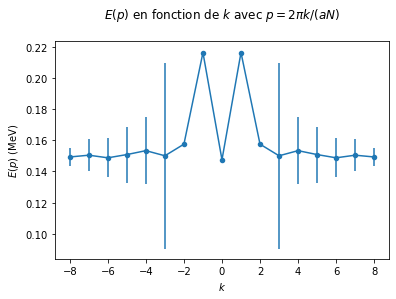

In [102]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S), np.array(sigmajn_g5S_g5S),marker=".", mew=2.5)
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

In [130]:
pi = [(2*np.pi*i)/(32) for i in range(-8,9)]

ValueError: 'x' and 'y' must have the same size

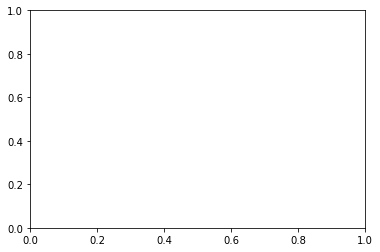

In [131]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S), np.array(sigmajn_g5S_g5S),marker=".", mew=2.5, label="E")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

Test $cosh(aE(p)) = cosh(am_H) + (1 − cos(ap_k))$

In [105]:
left_side = np.cosh(np.array(E0_g5S_g5S))

In [106]:
N= 32

In [107]:
cos_ap = np.cos(np.array([(2*np.pi*i)/(N) for i in range(-8, 9)]))

In [108]:
right_side = np.cosh(np.ones(17)*E0_g5S_g5S[8]) + np.ones(17) - cos_ap

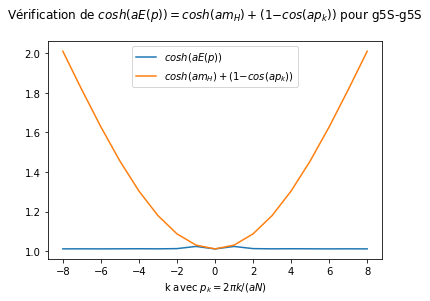

In [109]:
absc = [i for i in range(-8,9)]
plt.plot(absc,left_side, label = r"$cosh(aE(p))$")
plt.plot(absc,right_side, label = r"$cosh(am_H) + (1 − cos(ap_k))$")
plt.title(r"Vérification de $cosh(aE(p)) = cosh(am_H) + (1 − cos(ap_k))$ pour g5S-g5S" + "\n")
plt.xlabel(r"k avec $p_k = 2 \pi k / (aN)$")
plt.legend()

In [110]:
invN = np.arccos(np.ones(8) + np.cosh(np.ones(8)*E0_g5S_g5S[8]) - np.cosh(np.array(E0_g5S_g5S[0:8])))/np.abs(np.array([i for i in range(-8,0)]))

In [111]:
print(np.array([(2*np.pi*i)/(a*N) for i in range(-8, 9)])**2)

[580.42293186 444.38630721 326.48789917 226.72770776 145.10573297
  81.62197479  36.27643324   9.06910831   0.           9.06910831
  36.27643324  81.62197479 145.10573297 226.72770776 326.48789917
 444.38630721 580.42293186]


In [112]:
print((np.array(E0_g5S_g5S)/a)**2)

[ 5.2434708   5.32386282  5.20576104  5.35193964  5.53188129  5.2973592
  5.83624377 10.99844503  5.11979786 10.99844503  5.83624377  5.2973592
  5.53188129  5.35193964  5.20576104  5.32386282  5.2434708 ]


# Vérification du processus d'extraction de l'effective energy

Vérfication du processus d'extraction de l'effective energy pour un fichier au hasard

In [145]:
nt, re, im = lecture("./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz6.m-0.3303_m-0.3303.n3.dat")
ntll, rell, imll = par_configs(nt,re,im)
nont = normes_par_nt(ntll, rell, imll)
remoy, sigmare, immoy, sigmaim = moyenne_re_im(rent, imnt)
nomoy, sigmaobs = moyenne_norme(nont)
xnt = [i for i in range(64)]

Text(0, 0.5, '$ln(C(n_t))$')

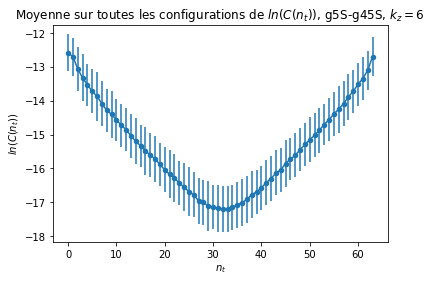

In [158]:
plt.errorbar(xnt,np.log(nomoy), (sigmaobs/np.abs(nomoy)), marker='.', mew=2.5)
plt.title("Moyenne sur toutes les configurations de $ln(C(n_t))$, g5S-g45S, $k_z=6$")
plt.xlabel(r"$n_t$")
plt.ylabel(r"$ln(C(n_t))$")

In [159]:
inf, sup = plateau(nomoy, sigmaobs)

In [160]:
print(inf, sup)

12 50


In [161]:
params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
print(params[2])

0.05083175486158312


Text(0, 0.5, '$C(n_t)$')

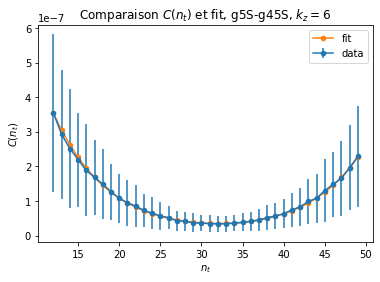

In [162]:
plt.errorbar(xdata, ydata, sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, ypred, marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $C(n_t)$ et fit, g5S-g45S, $k_z=6$")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$C(n_t)$")

Text(0, 0.5, '$ln(C(n_t))$')

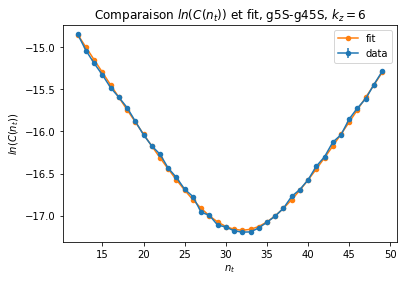

In [163]:
plt.errorbar(xdata, np.log(ydata), sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, np.log(ypred), marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $ln(C(n_t))$ et fit, g5S-g45S, $k_z=6$")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$ln(C(n_t))$")

In [164]:
def func_meff(meff, nt, NTT, c):
    return np.cosh(meff*(nt-NTT/2))/np.cosh(meff*(nt+1-NTT/2)) - c

In [165]:
def solve_meff(y, inf, sup):
    meff = []
    ycorr = []
    for i in range(len(y)-1):
        ycorr.append(y[i]/y[i+1])
    for i in range(inf,(sup-1)):
        meff.append((fsolve(func_meff, 0.15, args=(i, 64, ycorr[i-inf])))[0])
    return meff

In [166]:
meffdata = solve_meff(nomoy, 0, len(nomoy))
mefffit = solve_meff(ypred, inf, sup)

In [167]:
print(meffdata)

[0.12604002364904365, 0.3575700003243835, 0.26311625265853833, 0.2072326306964636, 0.1872393085171042, 0.14915490193500097, 0.21970883735476257, 0.19249781700998966, 0.12140950134416238, 0.16035957823853317, 0.16463049225307716, 0.12498447599591142, 0.19104526721564735, 0.15302889853531063, 0.13882739994585963, 0.15404318491908756, 0.11906811639061435, 0.1282262659837039, 0.16602375747422105, 0.1659221110757177, 0.1410290518885148, 0.117064724747704, 0.17703488184671065, 0.1350703302132352, 0.16541183338223817, 0.12666943954648183, 0.22210546570341402, 0.09270408696467093, 0.19455504164213083, 0.09658783834853578, 0.17589149189168862, 0.17664566640308849, 0.07014320694781818, 0.17915054397301738, 0.16962443368182942, 0.15057172527388454, 0.15388248710166647, 0.18409757027323825, 0.12288857796680104, 0.14526108127138085, 0.1770475737729711, 0.13161413644730172, 0.18158208575637075, 0.10437204300358793, 0.19088742195546154, 0.13633758505412366, 0.11684508906984807, 0.17004878947975735, 0

Text(0, 0.5, '$m_{eff}$')

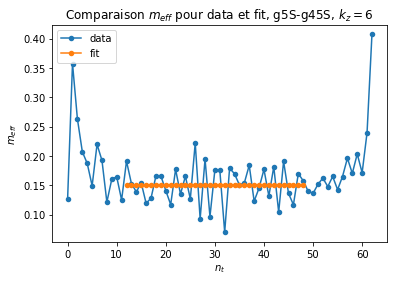

In [168]:
plt.plot(range(len(nomoy)-1), meffdata,marker=".", mew=2.5, label="data")
plt.plot(range(inf, (sup-1)), mefffit,marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $m_{eff}$ pour data et fit, g5S-g45S, $k_z=6$")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$m_{eff}$")

La détermination du plateau et le fit fonctionnent correctement

## Vérification de la fonction à fit ? sinh ? exp ?

On va maintenant appliquer ce processus à tous les 8 combinaisons d'opérateurs source/sink disponibles.

## pion-g5-S pion-g5-P

In [119]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [120]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g5P = []
E0unb_g5S_g5P = []
sigmajn_g5S_g5P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g5P.append(E0)
    E0unb_g5S_g5P.append(E0unb)
    sigmajn_g5S_g5P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


600
700
800
900
E0 biased= 0.15356576187767854 +/- 0.03728429504602477
M biased = 464.76489408031716 +/- 112.84046148078114 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1554157335975643 +/- 0.04299244911772537
M biased = 470.3638107915119 +/- 130.11611974008275 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1534588156289081 +/- 0.05745424832868967
M biased = 464.4412225706373 +/- 173.88457760667714 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15341528467235016 +/- 0.054048100903147614
M biased = 464.3094766647369 +/- 163.57591421649403 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,

In [121]:
donnees_g5S_g5P = np.array(list(zip(E0_g5S_g5P, E0unb_g5S_g5P, sigmajn_g5S_g5P)))
np.savetxt('__g5S_g5P.dat', donnees_g5S_g5P, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

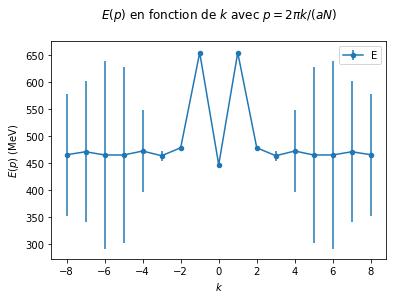

In [122]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="E")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g45-S

In [123]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [124]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g45S = []
E0unb_g45S_g45S = []
sigmajn_g45S_g45S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g45S.append(E0)
    E0unb_g45S_g45S.append(E0unb)
    sigmajn_g45S_g45S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15327631020251867 +/- 0.012594577312538744
M biased = 463.8888721370001 +/- 38.117333701707565 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1538324806967042 +/- 0.01016954145951547
M biased = 465.57211531347474 +/- 30.777992447573766 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15300408509236518 +/- 0.011940831516870962
M biased = 463.064986181306 +/- 36.138780072539824 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15312

In [125]:
donnees_g45S_g45S = np.array(list(zip(E0_g45S_g45S, E0unb_g45S_g45S, sigmajn_g45S_g45S)))
np.savetxt('__g45S_g45S.dat', donnees_g45S_g45S, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

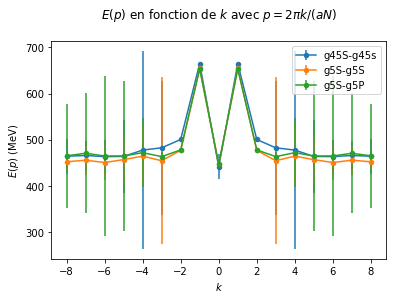

In [126]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45S)*x, np.array(sigmajn_g45S_g45S)*x,marker=".", mew=2.5, label="g45S-g45s")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S)*x, np.array(sigmajn_g5S_g5S)*x,marker=".", mew=2.5, label="g5S-g5S")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="g5S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g45-P

In [127]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [128]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g45P = []
E0unb_g45S_g45P = []
sigmajn_g45S_g45P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g45P.append(E0)
    E0unb_g45S_g45P.append(E0unb)
    sigmajn_g45S_g45P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16158251243770247 +/- 0.033457344195057484
M biased = 489.027491285192 +/- 101.25824168678082 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


400
500
600
700
800
900
E0 biased= 0.16019922278105175 +/- 0.046990829958157544
M biased = 484.8409821122179 +/- 142.21717029376313 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16044410812195134 +/- 0.03628677510864327
M biased = 485.58212459172233 +/- 109.82147962980447 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15931872532945288 +/- 0.05233325526289069
M biased = 482.17616737860357 +/- 158.38595492730727 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16136996993054506 +/- 0.021473272396536867
M biased = 488.38423399516364 +/- 64.98859543238392 MeV
Estimation de l'énergie effective de ./dat

In [129]:
donnees_g45S_g45P = np.array(list(zip(E0_g45S_g45P, E0unb_g45S_g45P, sigmajn_g45S_g45P)))
np.savetxt('__g45S_g45P.dat', donnees_g45S_g45P, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

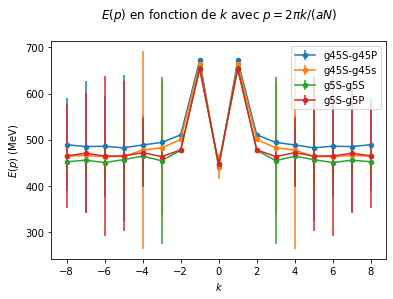

In [130]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45P)*x, np.array(sigmajn_g45S_g45P)*x,marker=".", mew=2.5, label="g45S-g45P")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45S)*x, np.array(sigmajn_g45S_g45S)*x,marker=".", mew=2.5, label="g45S-g45s")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S)*x, np.array(sigmajn_g5S_g5S)*x,marker=".", mew=2.5, label="g5S-g5S")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="g5S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g5-S

In [131]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [132]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g5S = []
E0unb_g45S_g5S = []
sigmajn_g45S_g5S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g5S.append(E0)
    E0unb_g45S_g5S.append(E0unb)
    sigmajn_g45S_g5S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15727590759781554 +/- 0.016978040634907397
M biased = 475.9936045790514 +/- 51.38383166203025 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15490405320302394 +/- 0.00737152673860084
M biased = 468.81521635572255 +/- 22.309835226194604 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1572158542302827 +/- 0.010811089660468065
M biased = 475.8118537990644 +/- 32.71963020599973 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1563230997

In [133]:
donnees_g45S_g5S = np.array(list(zip(E0_g45S_g5S, E0unb_g45S_g5S, sigmajn_g45S_g5S)))
np.savetxt('__g45S_g5S.dat', donnees_g45S_g5S, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

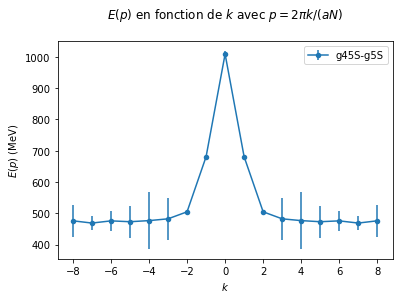

In [134]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g5S)*x, np.array(sigmajn_g45S_g5S)*x,marker=".", mew=2.5, label="g45S-g5S")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g5-P

In [135]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g5P = []
E0unb_g45S_g5P = []
sigmajn_g45S_g5P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g5P.append(E0)
    E0unb_g45S_g5P.append(E0unb)
    sigmajn_g45S_g5P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16484763950693523 +/- 0.05432133380261219
M biased = 498.9093582973162 +/- 164.40285023417266 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16277037403098302 +/- 0.05819316609110457
M biased = 492.62253982226673 +/- 176.1209031481502 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1639262326888807 +/- 0.0361058116961287
M biased = 496.1207318680793 +/- 109.27379608223909 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


900
E0 biased= 0.1616340497830884 +/- 0.07001815808395202
M biased = 489.18346842864247 +/- 211.90909632257674 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16512135811267922 +/- 0.06916852921802073
M biased = 499.73776429908986 +/- 209.33770498472975 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-3.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16648667755512747 +/- 0.027482678331872602
M biased = 503.8698868392737 +/- 83.17598876063536 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-2.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1690041162728828 +/- 0.0010322350936308412
M biased = 511.4888842297416 +/- 3.12404684541247 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,

In [136]:
donnees_g45S_g5P = np.array(list(zip(E0_g45S_g5P, E0unb_g45S_g5P, sigmajn_g45S_g5P)))
np.savetxt('__g45S_g5P.dat', donnees_g45S_g5P, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

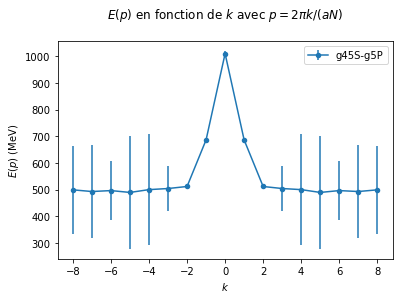

In [137]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g5P)*x, np.array(sigmajn_g45S_g5P)*x,marker=".", mew=2.5, label="g45S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g5-S pion-g45-S

In [138]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g45S = []
E0unb_g5S_g45S = []
sigmajn_g5S_g45S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g45S.append(E0)
    E0unb_g5S_g45S.append(E0unb)
    sigmajn_g5S_g45S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15174059508799193 +/- 0.00749084549447106
M biased = 459.2410491860152 +/- 22.670951976802012 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


200
300
400
500
600
700
800
900
E0 biased= 0.1514129284402821 +/- 0.005172899665083178
M biased = 458.249370097171 +/- 15.655717365212706 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15038033992061767 +/- 0.007127924459433021
M biased = 455.1242536122044 +/- 21.572575917278222 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15161408658711736 +/- 0.012925721915495868
M biased = 458.8581727603698 +/- 39.119538779433334 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.153344448420903 +/- 0.013167986709190862
M biased = 464.09509161888855 +/- 39.85275020497708 MeV
Estimation de l'énergie effective de ./da

In [139]:
donnees_g5S_g45S = np.array(list(zip(E0_g5S_g45S, E0unb_g5S_g45S, sigmajn_g5S_g45S)))
np.savetxt('__g5S_g45S.dat', donnees_g5S_g45S, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

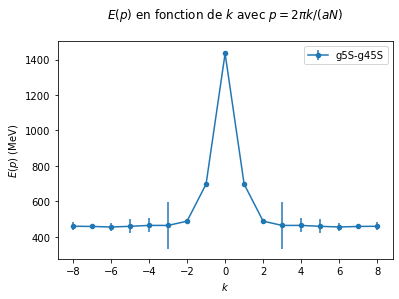

In [140]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g45S)*x, np.array(sigmajn_g5S_g45S)*x,marker=".", mew=2.5, label="g5S-g45S")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g5-S pion-g45-P

In [141]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g45P = []
E0unb_g5S_g45P = []
sigmajn_g5S_g45P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g45P.append(E0)
    E0unb_g5S_g45P.append(E0unb)
    sigmajn_g5S_g45P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15261468285831642 +/- 0.034577876935691906
M biased = 461.8864650978989 +/- 104.64952027744292 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15407562055179064 +/- 0.04929966808349786
M biased = 466.30797510158277 +/- 149.20484055080343 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15355220078667628 +/- 0.04150482202776347
M biased = 464.72385160479257 +/- 125.61383460540618 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1530517

In [142]:
donnees_g5S_g45P = np.array(list(zip(E0_g5S_g45P, E0unb_g5S_g45P, sigmajn_g5S_g45P)))
np.savetxt('__g5S_g45P.dat', donnees_g5S_g45P, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

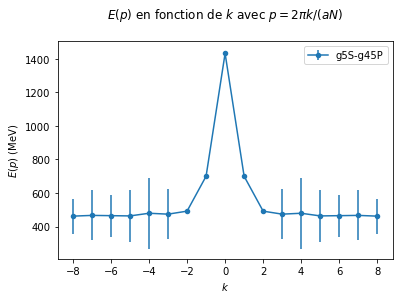

In [143]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g45P)*x, np.array(sigmajn_g5S_g45P)*x,marker=".", mew=2.5, label="g5S-g45P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

In [144]:
donnees_g5S_g5S = np.array(list(zip(E0_g5S_g5S, E0unb_g5S_g5S, sigmajn_g5S_g5S)))
np.savetxt('_g5S_g5S.dat', donnees_g5S_g5S, fmt='%.20f', delimiter='\t')
donnees_g5S_g5P = np.array(list(zip(E0_g5S_g5P, E0unb_g5S_g5P, sigmajn_g5S_g5P)))
np.savetxt('_g5S_g5P.dat', donnees_g5S_g5P, fmt='%.20f', delimiter='\t')
donnees_g5S_g45S = np.array(list(zip(E0_g5S_g45S, E0unb_g5S_g45S, sigmajn_g5S_g45S)))
np.savetxt('_g5S_g45S.dat', donnees_g5S_g45S, fmt='%.20f', delimiter='\t')
donnees_g5S_g45P = np.array(list(zip(E0_g5S_g45P, E0unb_g5S_g45P, sigmajn_g5S_g45P)))
np.savetxt('_g5S_g45P.dat', donnees_g5S_g45P, fmt='%.20f', delimiter='\t')
donnees_g45S_g5S = np.array(list(zip(E0_g45S_g5S, E0unb_g45S_g5S, sigmajn_g45S_g5S)))
np.savetxt('_g45S_g5S.dat', donnees_g45S_g5S, fmt='%.20f', delimiter='\t')
donnees_g45S_g5P = np.array(list(zip(E0_g45S_g5P, E0unb_g45S_g5P, sigmajn_g45S_g5P)))
np.savetxt('_g45S_g5P.dat', donnees_g45S_g5P, fmt='%.20f', delimiter='\t')
donnees_g45S_g45S = np.array(list(zip(E0_g45S_g45S, E0unb_g45S_g45S, sigmajn_g45S_g45S)))
np.savetxt('_g45S_g45S.dat', donnees_g45S_g45S, fmt='%.20f', delimiter='\t')
donnees_g45S_g45P = np.array(list(zip(E0_g45S_g45P, E0unb_g45S_g45P, sigmajn_g45S_g45P)))
np.savetxt('_g45S_g45P.dat', donnees_g45S_g45P, fmt='%.20f', delimiter='\t')